# 참고사이트

https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/extract-data-from-raster/

In [29]:
import geopandas as gpd

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent

In [3]:
# Rasterstats contains the zonalstatistics function 
# that you will use to extract raster values
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep

# Set consistent plotting style
sns.set_style("white")
sns.set(font_scale=1.5)

# Download data and set working directory 
data = et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

Extracted output to C:\Users\web1mhz\earth-analytics\data\spatial-vector-lidar\.


In [22]:
os.chdir(r'C:\python_work\tf115_work\machine_learing_reference')

In [12]:
# Load & plot the data
sjer_lidar_chm_path = os.path.join("data","spatial-vector-lidar", "california", "neon-sjer-site","2013", "lidar", "SJER_lidarCHM.tif")
sjer_lidar_chm_path

'data\\spatial-vector-lidar\\california\\neon-sjer-site\\2013\\lidar\\SJER_lidarCHM.tif'

In [16]:
file_path =r"C:\python_work\tf115_work\machine_learing_reference\data\spatial-vector-lidar\california\neon-sjer-site\2013\lidar\SJER_lidarCHM.tif"

rio.open(file_path )

<open DatasetReader name='C:\python_work\tf115_work\machine_learing_reference\data\spatial-vector-lidar\california\neon-sjer-site\2013\lidar\SJER_lidarCHM.tif' mode='r'>

In [17]:
with rio.open(file_path) as sjer_lidar_chm_src:
    # Masked = True sets no data values to np.nan if they are in the metadata
    SJER_chm_data = sjer_lidar_chm_src.read(1, masked=True)
    sjer_chm_meta = sjer_lidar_chm_src.profile

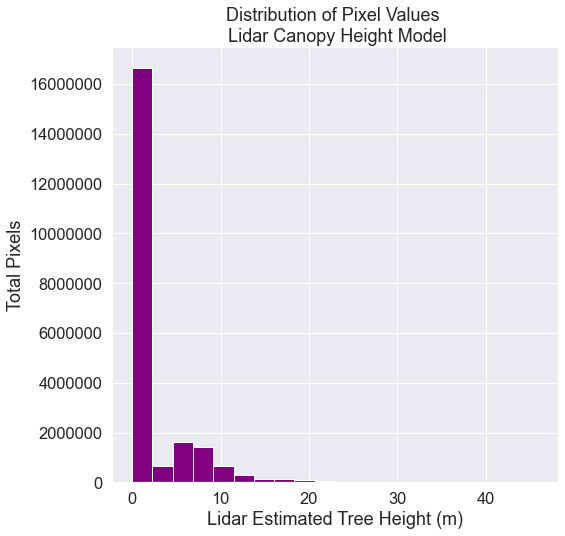

In [18]:
# Explore the data by plotting a histogram with earthpy
ax=ep.hist(SJER_chm_data,
        figsize=(8,8),
        colors="purple",
        xlabel="Lidar Estimated Tree Height (m)",
        ylabel="Total Pixels",
        title="Distribution of Pixel Values \n Lidar Canopy Height Model")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                     style='plain')

In [21]:
# EXPLORE: View summary statistics of canopy height model
# Notice the mean value with 0's included in the data
print('Mean:', np.nanmean(SJER_chm_data))
print('Max:', np.nanmax(SJER_chm_data))
print('Min:', np.nanmin(SJER_chm_data))

Mean: 1.9355862
Max: 45.879997
Min: 0.0


In [25]:
# CLEANUP: Set CHM values of 0 to NAN (no data or not a number)
SJER_chm_data[SJER_chm_data == 0] = np.nan

# View summary statistics of canopy height model after cleaning up the data
print('Mean:', np.nanmean(SJER_chm_data))
print('Max:', np.nanmax(SJER_chm_data))
print('Min:', np.nanmin(SJER_chm_data))

Mean: 8.213505
Max: 45.879997
Min: 2.0


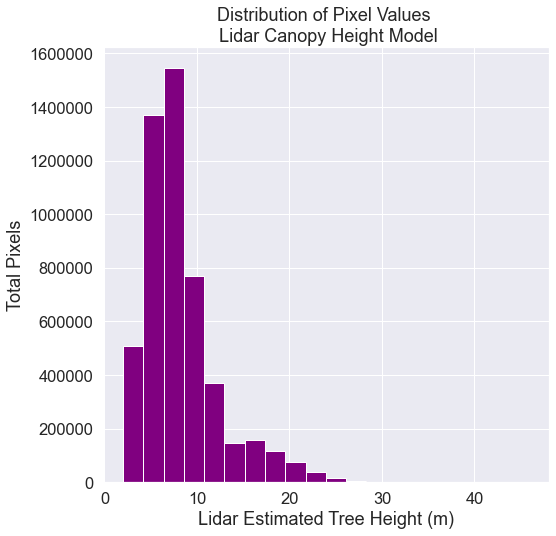

In [26]:
# Explore the data by plotting a histogram with earthpy
ax=ep.hist(SJER_chm_data,
        figsize=(8,8),
        colors="purple",
        xlabel="Lidar Estimated Tree Height (m)",
        ylabel="Total Pixels",
        title="Distribution of Pixel Values \n Lidar Canopy Height Model")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                     style='plain')

In [30]:
# data/spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_plot_centroids.shp

sjer_centroids_path = os.path.join("data", "spatial-vector-lidar", 
                                   "california", "neon-sjer-site", 
                                   "vector_data", "SJER_plot_centroids.shp")

SJER_plots_points = gpd.read_file(sjer_centroids_path)

type(SJER_plots_points)

geopandas.geodataframe.GeoDataFrame

In [32]:
SJER_plots_points.geom_type.head()

0    Point
1    Point
2    Point
3    Point
4    Point
dtype: object

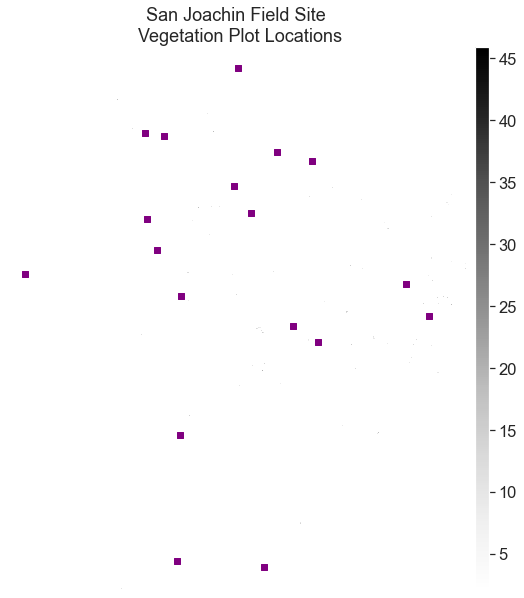

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))

ep.plot_bands(SJER_chm_data,
              extent=plotting_extent(sjer_lidar_chm_src), # Set spatial extent 
              cmap='Greys',
              title="San Joachin Field Site \n Vegetation Plot Locations",
              scale=False,
              ax=ax)

SJER_plots_points.plot(ax=ax,
                       marker='s',
                       markersize=45,
                       color='purple')
ax.set_axis_off()
plt.show()

In [34]:
# Create a buffered polygon layer from your plot location points
SJER_plots_poly = SJER_plots_points.copy()

# Buffer each point using a 20 meter circle radius 
# and replace the point geometry with the new buffered geometry
SJER_plots_poly["geometry"] = SJER_plots_points.geometry.buffer(20)
SJER_plots_poly.head()

,Plot_ID,Point,northing,easting,plot_type,geometry
0,SJER1068,center,4111567.818,255852.376,trees,"POLYGON ((255872.376 4111567.818, 255872.280 4..."
1,SJER112,center,4111298.971,257406.967,trees,"POLYGON ((257426.967 4111298.971, 257426.871 4..."
2,SJER116,center,4110819.876,256838.760,grass,"POLYGON ((256858.760 4110819.876, 256858.664 4..."
3,SJER117,center,4108752.026,256176.947,trees,"POLYGON ((256196.947 4108752.026, 256196.851 4..."
4,SJER120,center,4110476.079,255968.372,grass,"POLYGON ((255988.372 4110476.079, 255988.276 4..."


In [35]:
# If the dir does not exist, create it
output_path = os.path.join("data", "spatial-vector-lidar", "outputs")

if not os.path.isdir(output_path):
    os.mkdir(output_path)

# Export the buffered point layer as a shapefile to use in zonal stats
plot_buffer_path = os.path.join(output_path, "plot_buffer.shp")
SJER_plots_poly.to_file(plot_buffer_path)

In [36]:
# Extract zonal stats
sjer_tree_heights = rs.zonal_stats(plot_buffer_path,
                                   SJER_chm_data,
                                   nodata=-999,
                                   affine=sjer_chm_meta['transform'],
                                   geojson_out=True,
                                   copy_properties=True,
                                   stats="count min mean max median")

# View object type
type(sjer_tree_heights)

list

In [37]:
# Turn extracted data into a pandas geodataframe
SJER_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)
SJER_lidar_height_df.head()

,geometry,Plot_ID,Point,northing,easting,plot_type,min,max,mean,count,median
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,2.04,19.049999,11.544348,161,12.62
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,2.10,24.019999,10.369277,443,7.87
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,2.82,16.070000,7.518398,643,6.80
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,3.24,11.059999,7.675347,245,7.93
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,3.38,5.740000,4.591176,17,4.45


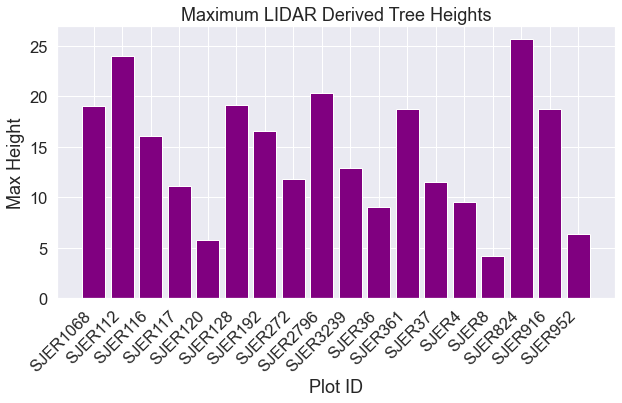

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(SJER_lidar_height_df['Plot_ID'],
       SJER_lidar_height_df['max'],
       color="purple")

ax.set(xlabel='Plot ID', ylabel='Max Height',
       title='Maximum LIDAR Derived Tree Heights')

plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [39]:
# Extract zonal stats but retain the individual pixel values
sjer_tree_heights_ras = rs.zonal_stats(plot_buffer_path,
                                       SJER_chm_data,
                                       nodata=-999,
                                       affine=sjer_chm_meta['transform'],
                                       geojson_out=True,
                                       raster_out=True,
                                       copy_properties=True,
                                       stats="count min mean max median")
# Convert to geodataframe
SJER_lidar_height_df_ras = gpd.GeoDataFrame.from_features(
    sjer_tree_heights_ras)

# View subset of the dataframe
SJER_lidar_height_df_ras[["Plot_ID", "count", "geometry",
                          "mini_raster_affine", "mini_raster_array"]].head()

,Plot_ID,count,geometry,mini_raster_affine,mini_raster_array
0,SJER1068,161,"POLYGON ((255872.376 4111567.818, 255872.280 4...","(1.0, 0.0, 255832.0, 0.0, -1.0, 4111588.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
1,SJER112,443,"POLYGON ((257426.967 4111298.971, 257426.871 4...","(1.0, 0.0, 257386.0, 0.0, -1.0, 4111319.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
2,SJER116,643,"POLYGON ((256858.760 4110819.876, 256858.664 4...","(1.0, 0.0, 256818.0, 0.0, -1.0, 4110840.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
3,SJER117,245,"POLYGON ((256196.947 4108752.026, 256196.851 4...","(1.0, 0.0, 256156.0, 0.0, -1.0, 4108773.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
4,SJER120,17,"POLYGON ((255988.372 4110476.079, 255988.276 4...","(1.0, 0.0, 255948.0, 0.0, -1.0, 4110497.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."


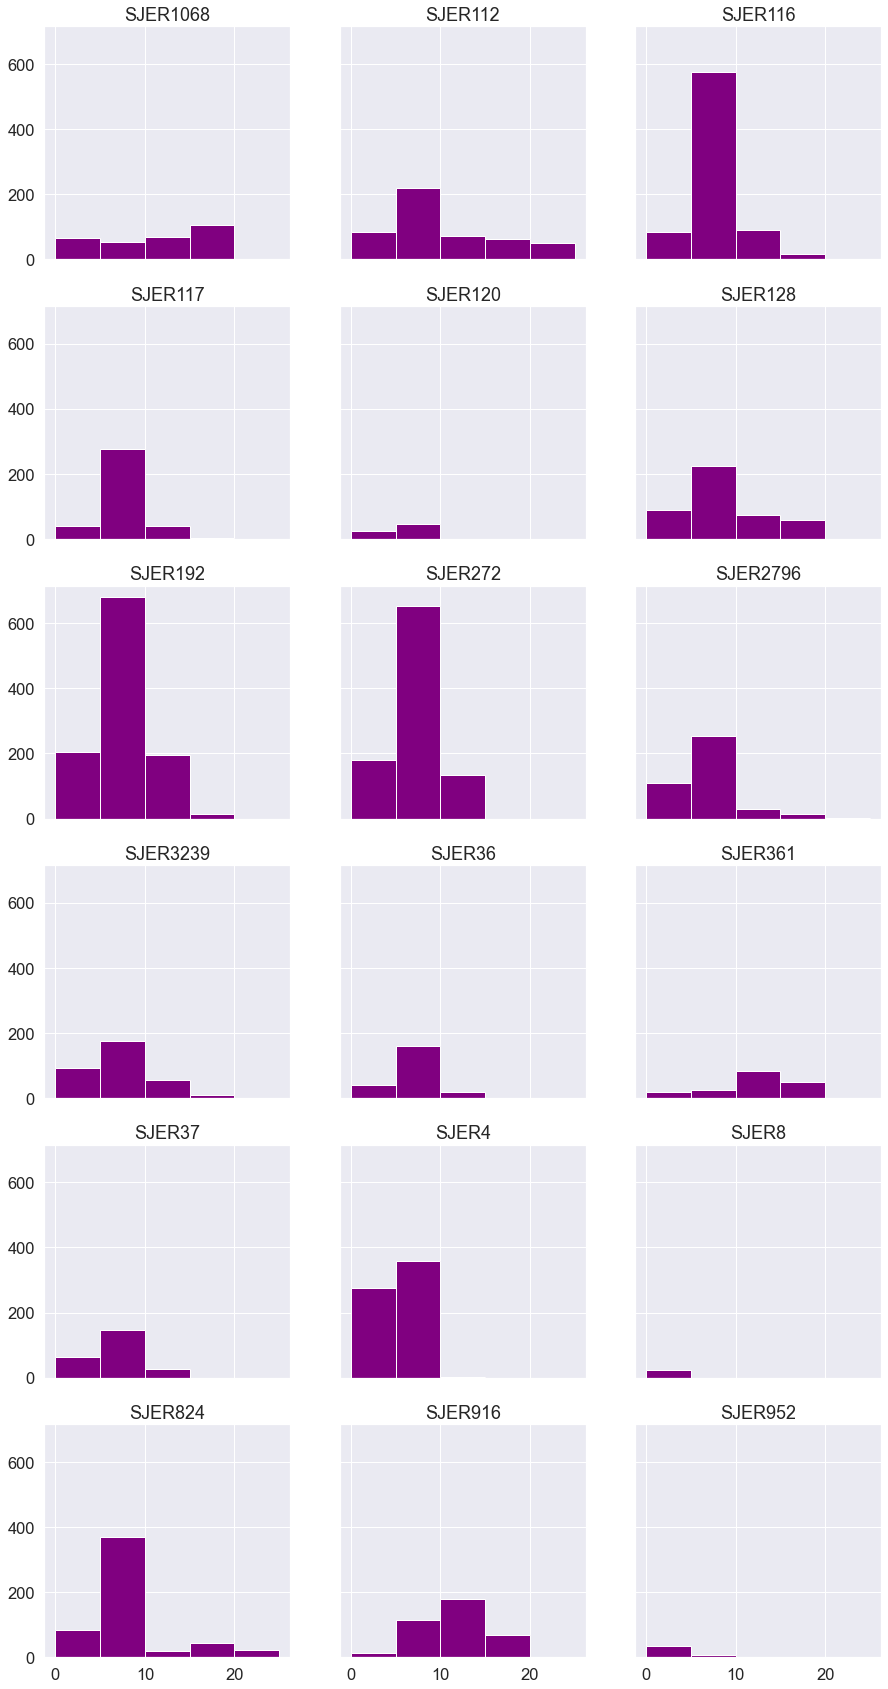

In [40]:
# Get list of sites
site_names = list(SJER_lidar_height_df_ras["Plot_ID"])

# Convert data in dataframe to a numpy array
arr = np.stack(SJER_lidar_height_df_ras['mini_raster_array'])

# Plot using earthpy
ep.hist(arr,
        bins=[0, 5, 10, 15, 20, 25],
        cols=3,
        title=site_names, figsize=(15, 30))

plt.show()

In [23]:
data=pd.read_csv("data/species3.csv", encoding="euc-kr")

In [24]:
data.head()

,species,lon,lat
0,백부자,128.341556,36.905056
1,백부자,128.344111,36.905611
2,백부자,128.343833,36.905500
3,백부자,128.343861,36.904472
4,백부자,128.343639,36.904528


In [7]:
altArray  = np.loadtxt("data/alt_110.asc", skiprows=6)
altArray.shape

(1234, 1929)

In [8]:
import linecache
lines =[]
lines.append(linecache.getline("data/alt_110.asc", 1))
lines.append (linecache.getline("data/alt_110.asc", 2))
lines.append ( linecache.getline("data/alt_110.asc", 3))
lines.append ( linecache.getline("data/alt_110.asc", 4))
lines.append ( linecache.getline("data/alt_110.asc", 5))
lines.append ( linecache.getline("data/alt_110.asc", 6))

In [9]:
for line in lines:
    print(line)

ncols         1929

nrows         1234

xllcorner     120

yllcorner     32.948310202094

cellsize      0.0083333333333333

NODATA_value  -9999



In [10]:
header = "ncols     %s\n" % altArray.shape[1]
header += "nrows    %s\n" % altArray.shape[0]
header += "xllcorner 120.0\n"
header += "yllcorner 32.948310202094\n"
header += "cellsize 0.0083333333333333\n"
header += "NODATA_value -9999\n"

In [11]:
f = open("data/myGrid.asc", "w")
f.write(header)
np.savetxt(f, altArray, fmt="%1.2f")
f.close()

In [12]:
with open("data/myGrid11.asc", "w") as f:
    f.write(header)
    np.savetxt(f, altArray, fmt="%1.2f")

In [13]:
with open("data/altArray1.asc", "w") as f:
    f.write(header)
    np.savetxt(f, altArray, fmt="%1.2f")